# __EDA__ (Exploratory Data Analysis) - PRELIMINAR

El objetivo principal de este proyecto es realizar un análisis exploratorio de datos sobre conjuntos de datos obtenidos de Google Maps y Yelp. El análisis tiene como finalidad comprender la estructura de los datos, identificar posibles outliers, gestionar valores faltantes, y descubrir patrones, tendencias y relaciones entre variables relevantes.

### IMPORTAMOS LIBRERIAS NECESARIAS

In [7]:
#Se importan las librerias
import pandas as pd # Una librería de análisis de datos.
import numpy as np # usaremos Nympy para los arreglos y matrices
import ast # proporciona herramientas para analizar y manipular código fuente de Python
import json # Formato común de los archivos
import pickle # Permite convertir objetos de Python en una secuencia de bytes que pueden ser almacenados en un archivo 
import matplotlib.pyplot as plt # Una librería para la visualización de datos en Python.
import seaborn as sns # Se utiliza para la visualización de datos.
from pyspark.sql import SparkSession # Se utiliza para crear una instancia de SparkSession, que es la entrada principal para trabajar con Spark SQL.
from pyspark.sql.functions import col, from_json, explode, sum,expr
from pyspark.sql.types import StructType, StructField, StringType, IntegerType # define varios tipos de datos y esquemas que se utilizan en Spark SQL. 

# __GOOGLE MAPS__

### Dataset: metadata-sitios

__RUTA DE LOS ARCHIVOS Y CREACIÓN DEL DATAFRAME__

In [9]:
# Crear una sesión de Spark
spark = SparkSession.builder.master("local").appName("EDA-Preliminar").getOrCreate()

# Lista para almacenar los DataFrames de metadatos
metadata_sitios = []

In [10]:
# Ruta local donde se encuentran los archivos JSON
ruta_local = "C:/Users/Usuario/Desktop/Proyecto Final/metadata-sitios"


# Iteración sobre los archivos JSON del 1 al 11
for i in range(1, 12):
    # Lectura del archivo JSON utilizando Spark
    archivo = spark.read.json(f"{ruta_local}/{i}.json")
    # Conversión de la columna "MISC" a tipo de datos "string"
    archivo = archivo.withColumn("MISC", col("MISC").cast("string"))
    # Agregar el DataFrame a la lista de metadatos
    metadata_sitios.append(archivo)

# DataFrame final para almacenar los datos combinados
df_final = metadata_sitios[0]

# Unión de los DataFrames de metadatos utilizando unionByName
for dataframe in metadata_sitios[1:]:
    df_final = df_final.unionByName(dataframe)

# Sobrescribir metadata_df con el DataFrame final combinado
metadata_sitios = df_final

In [11]:
# Mostrar el DataFrame
metadata_sitios.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{[Wheelchair acce...|Porter Pharmacy, ...|       4.9|          [Pharmacy]|                NULL|0x88f16e41928ff68...|[[Friday, 8AM–6PM...|           32

In [12]:
#Muestra el número de filas del DataFrame
metadata_sitios.count()

3025011

Comenzamos a analizar este DataFrame sobre los diferentes negocios en los Estados Unidos, entre los datos podemos encontrar diferentes categorías como farmacias, restaurantes, cafeterias, gimnasios,... etc. Para nuestro proyecto es importante enfocarnos en el **_sector gastronómico_**, sin embargo en este Análisis de datos preliminar abarcaré el estudio de la calidad de los datos en general. En primera instancia, no tenemos una columna que indique explícitamente el Estado en el que se encuentra el negocio, sin embargo a futuro podemos construir una función que nos proporcione ese dato a partir de las coordenadas.

Comenzamos contando el número de registros de nuestro dataset para tener una **dimensión del conjunto de datos** que manejamos: **3025011**. Ahora es importante conocer qué cantidad de datos faltan en cada columna para saber si es proporcionalmente admisible.

In [13]:
# Cuenta el número de nulos en cada columna

def conteo_nulos(dataframe):
  conteo_nulos_por_columna = dataframe.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in dataframe.columns])

  # Muestra el resultado
  conteo_nulos_por_columna.show()

In [14]:
conteo_nulos(metadata_sitios)

+------+-------+----------+--------+-----------+-------+------+--------+---------+----+--------------+-------+----------------+------+---+
|  MISC|address|avg_rating|category|description|gmap_id| hours|latitude|longitude|name|num_of_reviews|  price|relative_results| state|url|
+------+-------+----------+--------+-----------+-------+------+--------+---------+----+--------------+-------+----------------+------+---+
|690834|  80511|         0|   17419|    2770722|      0|787405|       0|        0|  37|             0|2749808|          295058|746455|  0|
+------+-------+----------+--------+-----------+-------+------+--------+---------+----+--------------+-------+----------------+------+---+



Como se puede observar los campos **_'description' y 'price'_** tienen **demasiados datos nulos** en proporción al total de registros como para ser siquiera considerados. También otras columnas como 'state' y 'MISC' no son de relevancia para nuestro estudio, pero esto se analizará más adelante cuando tengamos que hacer el ETL y normalizar los Datasets.

Ahora nos interesa conocer las categorías de negocio en específico que contienen nuestros datos.

In [15]:
# Visualización de las primeras filas del DataFrame
print(metadata_sitios.head())

Row(MISC='{[Wheelchair accessible entrance], null, null, null, null, null, null, null, [Mask required, Staff required to disinfect surfaces between visits], null, null, null, [Quick visit], null, null, [In-store shopping, Same-day delivery]}', address='Porter Pharmacy, 129 N Second St, Cochran, GA 31014', avg_rating=4.9, category=['Pharmacy'], description=None, gmap_id='0x88f16e41928ff687:0x883dad4fd048e8f8', hours=[['Friday', '8AM–6PM'], ['Saturday', '8AM–12PM'], ['Sunday', 'Closed'], ['Monday', '8AM–6PM'], ['Tuesday', '8AM–6PM'], ['Wednesday', '8AM–12PM'], ['Thursday', '8AM–6PM']], latitude=32.3883, longitude=-83.3571, name='Porter Pharmacy', num_of_reviews=16, price=None, relative_results=['0x88f16e41929435cf:0x5b2532a2885e9ef6', '0x88f16c32716531c1:0x5f19bdaa5044e4fa', '0x88f16e6e3f4a21df:0xcf495da9bb4d89ea'], state='Open ⋅ Closes 6PM', url='https://www.google.com/maps/place//data=!4m2!3m1!1s0x88f16e41928ff687:0x883dad4fd048e8f8?authuser=-1&hl=en&gl=us')


In [16]:
# Información general del DataFrame
metadata_sitios.printSchema()

root
 |-- MISC: string (nullable = true)
 |-- address: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- hours: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- num_of_reviews: long (nullable = true)
 |-- price: string (nullable = true)
 |-- relative_results: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- state: string (nullable = true)
 |-- url: string (nullable = true)



In [17]:
# Estadísticas descriptivas para columnas numéricas
print(metadata_sitios.describe())

DataFrame[summary: string, MISC: string, address: string, avg_rating: string, description: string, gmap_id: string, latitude: string, longitude: string, name: string, num_of_reviews: string, price: string, state: string, url: string]


In [18]:
# Explota la columna 'category' y obtiene elementos únicos
categorias_sin_duplicados = metadata_sitios.select(explode("category").alias("categoria")).distinct()

# Colecta los resultados en una lista
lista_categorias_sin_duplicados = [row.categoria for row in categorias_sin_duplicados.collect()]

# Muestra la lista resultante
print("Categorías sin duplicados:", lista_categorias_sin_duplicados)

# Muestra cuantas categorías hay en total

print("El número de categorías es: ", len(lista_categorias_sin_duplicados))

#Ahora voy a contar cuantas de esas categorías son de restaurantes

contador=0

for elemento in lista_categorias_sin_duplicados:

  if 'restaurant' in elemento:

    contador+=1

print(f"Los restaurantes abarcan el {round(contador*100/len(lista_categorias_sin_duplicados),2)}% de las categorías")

Categorías sin duplicados: ['Art gallery', 'Dry wall contractor', 'Sports massage therapist', 'Tile store', 'Basketball club', 'Leather coats store', 'Public relations firm', 'Central American restaurant', 'Taxicab Stand', 'Deck builder', 'Professional organizer', 'Textile mill', 'Racquetball club', 'RV dealer', 'Water works equipment supplier', 'Mental health', 'Curtain supplier and maker', 'Timeshare agency', 'Dog cafe', 'Pony ride service', 'Mobile home park', 'Emergency room', 'Landscape lighting designer', 'Plastic surgeon', 'Gay bar', 'Data recovery service', 'Wedding bakery', 'Market', 'Salvage dealer', 'Services', 'Mercedes-Benz dealer', 'Mens tailor', 'Orthodox church', 'Computer accessories store', 'Educational testing service', 'Haunted house', 'Apartment rental agency', 'Cardiologist', 'Pet boarding service', 'Surgical center', 'Rehabilitation center', 'Tack shop', 'Airline ticket agency', 'Environmental organization', 'Curtain store', 'Golf driving range', 'Dessert restaur

Es de interés conocer cuantos de los registros tienen la cadena 'restaurant' en alguna de sus categorías, esto es lo mismo que responder a la pregunta: ¿Cuántos de estos negocios son restaurantes?.

In [19]:
df_aux = metadata_sitios.withColumn("category", col("category").cast("string"))

# Filtra y cuenta las filas que contienen 'restaurant' en la columna 'category'
contador_restaurant = df_aux.filter(col("category").contains('restaurant')).count()


# Imprime el resultado
print("El número de restaurantes es:", contador_restaurant)

El número de restaurantes es: 152198


Esto quiere decir que aproximadamente el 5% de los registros del Dataset "metadata_sitios" corresponde a restaurantes, conocer esto es de bastante utilidad para dimensionar el tamaño de los archivos que vamos a normalizar y cargar en nuestra base de datos.

In [20]:
df_aux = metadata_sitios.withColumn("category", col("category").cast("string"))

# Filtra y cuenta las filas que contienen ' Pizzas restaurant' en la columna 'category'
contador_fastfood = df_aux.filter(col("category").contains('Pizza restaurant')).count()


# Imprime el resultado
print("El número de restaurantes de pizzeria es:", contador_fastfood)
print(f"Representa el: {round(contador_fastfood*100/contador_restaurant,2)}% de los restaurantes")

El número de restaurantes de pizzeria es: 23814
Representa el: 15.65% de los restaurantes


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


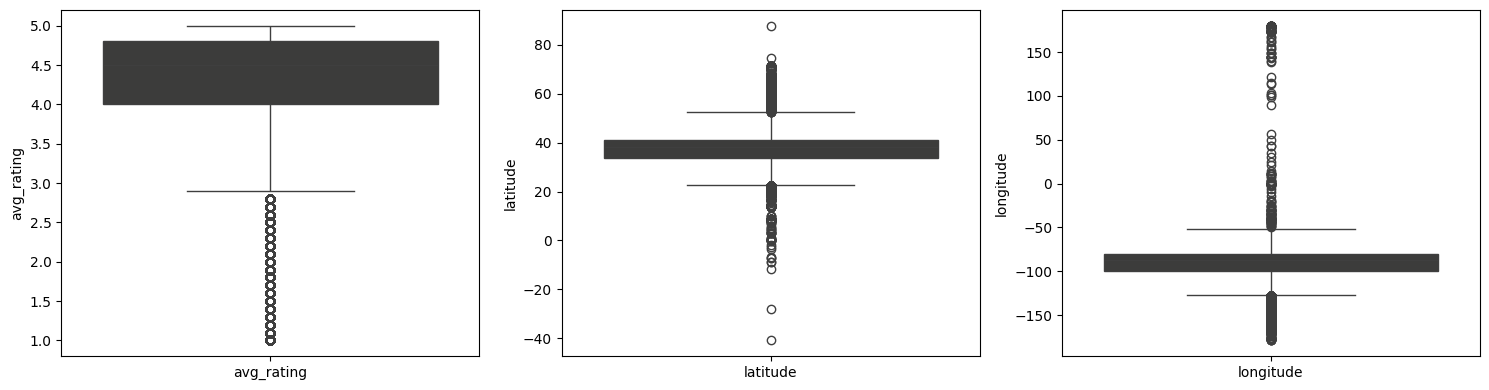

In [23]:
# Obtener las columnas numéricas
columnas_numericas = [column[0] for column in metadata_sitios.dtypes if column[1] in ('int', 'double')]

# Crear subplots para los gráficos
fig, axs = plt.subplots(1, len(columnas_numericas), figsize=(15, 4))

# Iterar sobre las columnas numéricas y generar boxplots
for i, columna in enumerate(columnas_numericas):
    sns.boxplot(data=metadata_sitios.select(col(columna)).toPandas(), ax=axs[i], color="#3C3C3B")
    axs[i].set_ylabel(columna)

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()

Proseguiremos a explorar los demás DataFrames, analizando los datos nulos de manera similar.

### DATASET: REVIEWS-NEW_YORK

In [24]:
# Ruta del directorio que contiene los archivos de reseñas de Nueva York
ruta_reviews_ny = r"C:/Users/Usuario/Desktop/Proyecto Final/review-New_York"

# Lista para almacenar los DataFrames de reseñas de Nueva York
reviews_NewYork = []

# Inicialización de variables
i = 1
bandera = True

# Bucle para leer los archivos JSON de reseñas de Nueva York
while bandera:
    try:
        # Lectura del archivo JSON utilizando Spark y agregándolo a la lista
        archivo = spark.read.json(f"{ruta_reviews_ny}/{i}.json")
        reviews_NewYork.append(archivo)
        i += 1
    except:
        # Finalización del bucle si no hay más archivos
        bandera = False
# DataFrame final para almacenar las reseñas de Nueva York combinadas
df_final_reviews_ny = reviews_NewYork[0]
# Unión de los DataFrames de reseñas de Nueva York
for dataframe in reviews_NewYork[1:]:
    df_final_reviews_ny = df_final_reviews_ny.unionByName(dataframe)
# Sobrescribir reviews_NewYork con el DataFrame final combinado
reviews_NewYork = df_final_reviews_ny

In [25]:
# Mostrar el DataFrame
reviews_NewYork.show()

+--------------------+--------------------+--------------------+------+--------------------+--------------------+-------------+--------------------+
|             gmap_id|                name|                pics|rating|                resp|                text|         time|             user_id|
+--------------------+--------------------+--------------------+------+--------------------+--------------------+-------------+--------------------+
|0x89c25fc9494dce4...|      Alvin Martinez|[{[https://lh5.go...|     5|                NULL|I'm late to posti...|1603494795361|11372210469230823...|
|0x89c25fc9494dce4...|     Johnnie Jackson|                NULL|     1|{We pride ourselv...|Very dissatisfied...|1620157037403|10729344149210932...|
|0x89c25fc9494dce4...|        Manie Blazer|                NULL|     5|                NULL|Excellent very we...|1597431662039|10037858580181940...|
|0x89c25fc9494dce4...|      Fashion Fiinds|                NULL|     5|{Thanks for the a...|Basing my revi

In [26]:
#Muestra el número de filas del DataFrame
reviews_NewYork.count()

2700000

In [27]:
conteo_nulos(reviews_NewYork)

+-------+----+-------+------+-------+-------+----+-------+
|gmap_id|name|   pics|rating|   resp|   text|time|user_id|
+-------+----+-------+------+-------+-------+----+-------+
|      0|   0|2598344|     0|2436003|1163593|   0|      0|
+-------+----+-------+------+-------+-------+----+-------+



En este caso las columnas **_'pics' y 'resp'_** tienen muchos datos nulos como para ser consideradas, de manera similar ocurre con el otro Estados. También nos damos cuenta que la columna 'gmap_id' jugará un papel clave para identificar cada negocio en el Dataset de metadata_sitios

In [28]:
# Visualización de las primeras filas del DataFrame
reviews_NewYork.head()

Row(gmap_id='0x89c25fc9494dce47:0x6d63c807b59a55', name='Alvin Martinez', pics=[Row(url=['https://lh5.googleusercontent.com/p/AF1QipMOL-t5pYhZ1mX9DKux9oKTJDFy_6R-3jLfwuEA=w150-h150-k-no-p'])], rating=5, resp=None, text="I'm late to posting this but this store especially this amazing representative made my entire month. Helpful kind attentive everything was handled and she did it with a smile. I need 12 more stores like this one instead of the ones on junction", time=1603494795361, user_id='113722104692308235141')

In [29]:
# Estructura del esquema del DataFrame 
reviews_NewYork.printSchema()

root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)



In [30]:
# Estadísticas descriptivas para columnas numéricas
reviews_NewYork.describe()

DataFrame[summary: string, gmap_id: string, name: string, rating: string, text: string, time: string, user_id: string]

In [31]:
# Eliminar duplicados basándote en todas las columnas
reviews_NewYork_no_duplicates = reviews_NewYork.dropDuplicates()

# Contar las filas después de eliminar duplicados
print("Número de filas después de eliminar duplicados:", reviews_NewYork_no_duplicates.count())


Número de filas después de eliminar duplicados: 2640663


In [32]:
# Calcular estadísticas descriptivas
estadisticas_rating = reviews_NewYork.describe('rating')

# Obtener cuartiles
q1_row = estadisticas_rating.filter(col('summary') == '25%').first()
q3_row = estadisticas_rating.filter(col('summary') == '75%').first()

# Verificar si las filas existen antes de acceder a sus elementos
if q1_row and q3_row:
    q1 = q1_row['rating']
    q3 = q3_row['rating']
    iqr = q3 - q1

    # Definir límites para outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identificar outliers
    outliers_rating = reviews_NewYork.filter((col('rating') < lower_bound) | (col('rating') > upper_bound))
else:
    print("No se encontraron cuartiles en las estadísticas.")

No se encontraron cuartiles en las estadísticas.


### DATASET: REVIEWS-CALIFORNIA

In [74]:
#Se leen los reviews de California

ruta_reviews_cf = r"C:/Users/Usuario/Desktop/Proyecto Final/reviews-California"
reviews_California=[]

i = 1
bandera = True

while bandera:
    try:
        archivo = spark.read.json(f"{ruta_reviews_cf}/{i}.json")
        reviews_California.append(archivo)
        i += 1
    except:
        bandera = False

df_final_reviews_cf = reviews_California[0]

for dataframe in reviews_California[1:]:
    df_final_reviews_cf = df_final_reviews_cf.unionByName(dataframe)
    
reviews_California = df_final_reviews_cf

In [75]:
reviews_California.show()

+--------------------+-------------+----+------+----+--------------------+-------------+--------------------+
|             gmap_id|         name|pics|rating|resp|                text|         time|             user_id|
+--------------------+-------------+----+------+----+--------------------+-------------+--------------------+
|0x80c2c778e3b73d3...|      Song Ro|NULL|     5|NULL|Love there korean...|1609909927056|10899115226265578...|
|0x80c2c778e3b73d3...|  Rafa Robles|NULL|     5|NULL|      Good very good|1612849648663|11129032221979621...|
|0x80c2c778e3b73d3...|    David Han|NULL|     4|NULL|They make Korean ...|1583643882296|11264035744961195...|
|0x80c2c778e3b73d3...|  Anthony Kim|NULL|     5|NULL|Short ribs are ve...|1551938216355|11744034972382365...|
|0x80c2c778e3b73d3...|Mario Marzouk|NULL|     5|NULL|Great food and pr...|1494910901933|10058077083612353...|
|0x80c2c778e3b73d3...|  Ana Salazar|NULL|     5|NULL|This food is deli...|1547799582640|10018573266445490...|
|0x80c2c77

In [76]:
# Conteo de Filas en el DataFrame
reviews_California.count()

2700000

In [77]:
conteo_nulos(reviews_California)

+-------+----+-------+------+-------+-------+----+-------+
|gmap_id|name|   pics|rating|   resp|   text|time|user_id|
+-------+----+-------+------+-------+-------+----+-------+
|      0|   0|2600710|     0|2454831|1170964|   0|      0|
+-------+----+-------+------+-------+-------+----+-------+



Coincidimos con el dataset de New York donde mayor cantidad de nulos hay son en las categorias pics y resp

In [78]:
# Visualización de las primeras filas del DataFrame
reviews_California.head()

Row(gmap_id='0x80c2c778e3b73d33:0xbdc58662a4a97d49', name='Song Ro', pics=None, rating=5, resp=None, text='Love there korean rice cake.', time=1609909927056, user_id='108991152262655788985')

In [79]:
#Estructura del esquema del dataframe
reviews_California.printSchema()

root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)



In [80]:
# Eliminar duplicados basándote en todas las columnas
reviews_California_no_duplicates = reviews_California.dropDuplicates()

# Contar las filas después de eliminar duplicados
print("Número de filas después de eliminar duplicados:", reviews_California_no_duplicates.count())


Número de filas después de eliminar duplicados: 2624758


In [82]:
# Calcular estadísticas descriptivas
estadisticas_rating = reviews_California.describe('rating')

# Obtener cuartiles
q1_row = estadisticas_rating.filter(col('summary') == '25%').first()
q3_row = estadisticas_rating.filter(col('summary') == '75%').first()

# Verificar si las filas existen antes de acceder a sus elementos
if q1_row and q3_row:
    q1 = q1_row['rating']
    q3 = q3_row['rating']
    iqr = q3 - q1

    # Definir límites para outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identificar outliers
    outliers_rating = reviews_NewYork.filter((col('rating') < lower_bound) | (col('rating') > upper_bound))
else:
    print("No se encontraron cuartiles en las estadísticas.")

No se encontraron cuartiles en las estadísticas.


# YELP

### DATASET: business.pkl

In [6]:
# Ruta local completa del archivo business.pkl
ruta_local_business = r"C:/Users/Usuario/Desktop/Proyecto Final/Yelp/business.pkl"

In [11]:
# Cargar el archivo pickle usando pd.read_pickle
business_yelp = pd.read_pickle(ruta_local_business)

In [12]:
# Mostramos las primeras 5 filas del dataframe
business_yelp.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
business_yelp.shape[0]

150346

In [84]:
# Mostramos la info del dataframe
business_yelp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   business_id   150346 non-null  object
 1   name          150346 non-null  object
 2   address       150346 non-null  object
 3   city          150346 non-null  object
 4   state         150343 non-null  object
 5   postal_code   150346 non-null  object
 6   latitude      150346 non-null  object
 7   longitude     150346 non-null  object
 8   stars         150346 non-null  object
 9   review_count  150346 non-null  object
 10  is_open       150346 non-null  object
 11  attributes    136602 non-null  object
 12  categories    150243 non-null  object
 13  hours         127123 non-null  object
dtypes: object(14)
memory usage: 17.2+ MB


- __Número de Filas y Columnas:__ Hay un total de 150346 filas y 28 columnas en el DataFrame.
- __Columnas y Tipos de Datos:__ El DataFrame consta de 28 columnas, donde cada columna representa una característica o atributo de los negocios de Yelp.
Las columnas contienen principalmente datos de tipo objeto (str).
- __Recuento de Valores no Nulos:__ Se muestra el recuento de valores no nulos para cada columna. Esto indica cuántos valores no nulos hay presentes en cada columna del DataFrame.
- __Uso de Memoria:__ El uso de memoria por el DataFrame se muestra al final, indicando la cantidad de memoria utilizada para almacenar los datos del DataFrame.

In [85]:
# Estadísticas descriptivas para columnas numéricas
print(business_yelp.describe())

                   business_id       name address          city   state  \
count                   150346     150346  150346        150346  150343   
unique                  150346     114117  122844          1416      27   
top     Pns2l4eNsfO8kk83dixA6A  Starbucks          Philadelphia      PA   
freq                         1        724    5127         14569   34039   

       postal_code       latitude      longitude     stars  review_count  \
count       150346  150346.000000  150346.000000  150346.0        150346   
unique        3362  135593.000000  131918.000000       9.0          1158   
top          93101      34.420334    -119.710749       4.0             5   
freq          1866     146.000000     146.000000   31125.0         14921   

        is_open                              attributes  \
count    150346                                  136602   
unique        2                                   67212   
top           1  {'BusinessAcceptsCreditCards': 'True'}   
freq   

In [14]:
def contar_nulos(dataframe):

    # Obtener la cantidad de valores nulos por columna
  nulos_por_columna = dataframe.isnull().sum()

  print("Cantidad de valores nulos por columna:\n", nulos_por_columna)
     

In [15]:
#Cuantos nulos hay en cada columna
contar_nulos(business_yelp)

Cantidad de valores nulos por columna:
 business_id          0
name                 0
address              0
city                 0
state                3
postal_code          0
latitude             0
longitude            0
stars                0
review_count         0
is_open              0
attributes       13744
categories         103
hours            23223
business_id     150341
name            150341
address         150341
city            150341
state           150341
postal_code     150341
latitude        150341
longitude       150341
stars           150341
review_count    150341
is_open         150341
attributes      150341
categories      150341
hours           150341
dtype: int64


In [16]:
#Elimina las columnas repetidas que tienen casi todos sus datos nulos
business_yelp=business_yelp.iloc[:,0:14]

Este Dataset 'business yelp' tiene muchas columnas repetidas, en su mayoría los datos de esas copias son nulos, para nuestro trabajo deben ser eliminadas. Es importante conocer el número de negocios que pertenecen a los Estados que son objeto de nuestro estudio

In [19]:
business_yelp[(business_yelp['state']=='NY') | ((business_yelp['state']=='CA'))].shape[0]

5203

In [22]:
#Analisamos el porcentaje total del datframe
proporcion= round(5203*100/150346,2)

print(f"El porcentaje de datos que corresponde a alguno de los dos Estados es: {proporcion}%")

El porcentaje de datos que corresponde a alguno de los dos Estados es: 3.46%


In [23]:
contador= 0
for elemento in business_yelp['categories']:

  try:

    if 'Restaurants' in elemento:

      contador+=1

  except:

    continue

print("La cantidad total de restaurantes es: ", contador)
print(f"Representan un {round(contador*100/150346,2)}% de los negocios")

La cantidad total de restaurantes es:  52268
Representan un 34.77% de los negocios


### DATASET: checkin.json

In [24]:
# Ruta local completa del archivo checkin.json
ruta_local_checkin = r"C:/Users/Usuario/Desktop/Proyecto Final/Yelp/checkin.json"

In [25]:
checkin_yelp = []

with open(ruta_local_checkin, "r", encoding='utf-8') as filejson:
    # Procesa cada línea del archivo como un objeto JSON
    for linea in filejson:
        # Intenta cargar la línea como un objeto JSON
        objeto = json.loads(linea)
        checkin_yelp.append(objeto)

# Convierte la lista de diccionarios a un DataFrame de Pandas
checkin_yelp = pd.DataFrame(checkin_yelp)


In [26]:
#MUestra las primero 5 filas del dataframe
checkin_yelp.head(5)

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


In [86]:
#Muesta la informacion del dataframe
checkin_yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131930 entries, 0 to 131929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  131930 non-null  object
 1   date         131930 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [27]:
checkin_yelp.shape[0]

131930

In [28]:
#Cuenta los nulos
contar_nulos(checkin_yelp)

Cantidad de valores nulos por columna:
 business_id    0
date           0
dtype: int64


En este analisis nos dimos cuenta que el archivo CHECKIN no tiene datos nulos

### DATASET: review.json

In [29]:
#Se lee el archivo review de yelp

review_yelp = spark.read.json("C:/Users/Usuario/Desktop/Proyecto Final/Yelp/review.json")

In [30]:
#Muestra eñ dataframe
review_yelp.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [31]:
#Conteo de todas las filas
review_yelp.count()

6990280

In [37]:
#Conteos datos nulos
conteo_nulos(review_yelp)

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|
+-----------+----+----+-----+---------+-----+----+------+-------+



In [87]:
# Muestra los datos
review_yelp.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [88]:
# Eliminar duplicados basándote en todas las columnas
reviews_yelp_no_duplicates = review_yelp.dropDuplicates()

# Contar las filas después de eliminar duplicados
print("Número de filas después de eliminar duplicados:", reviews_yelp_no_duplicates.count())

En este caso no hay valores nulos, lo que es bastante positivo para nuestro sistema de recomendación y para facilitar la limpieza de datos.

### DATASET: tip.json

In [38]:
#Se lee el archivo tip de yelp

tip_yelp=[]

with open("C:/Users/Usuario/Desktop/Proyecto Final/Yelp/tip.json","r", encoding= 'utf-8') as filejson:


                # Procesa cada línea del archivo como un objeto JSON
                for linea in filejson:

                        # Intenta cargar la línea como un objeto JSON
                        objeto = json.loads(linea)

                        tip_yelp.append(objeto)

tip_yelp=pd.DataFrame(tip_yelp)

In [39]:
tip_yelp.head(5)

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


In [40]:
tip_yelp.shape[0]

908915

In [41]:
contar_nulos(tip_yelp)

Cantidad de valores nulos por columna:
 user_id             0
business_id         0
text                0
date                0
compliment_count    0
dtype: int64


### DATASET: user.parquet

In [43]:
#Se lee el archivo user de yelp

user_yelp= pd.read_parquet("C:/Users/Usuario/Desktop/Proyecto Final/Yelp/user.parquet")

In [44]:
user_yelp.head(5)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [45]:
user_yelp.shape[0]

2105597

In [46]:
contar_nulos(user_yelp)

Cantidad de valores nulos por columna:
 user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64


Como se pudo observar, los datos de Yelp no necesitan mayor tratamiento en cuanto a datos faltantes.